#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install -q scikit-learn==1.5.0
!pip install -q matplotlib==3.4.3
!pip install -q phik
!pip install -q workalendar

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import phik
import sklearn
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import (mean_squared_error,
                             root_mean_squared_error)
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV,
                                     cross_val_score,
                                    TimeSeriesSplit)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (OneHotEncoder,  
                                   StandardScaler, 
                                   MinMaxScaler, 
                                   RobustScaler) 
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.neighbors import KNeighborsRegressor 
from sklearn.tree import  DecisionTreeRegressor  
from sklearn.ensemble import RandomForestRegressor 
from sklearn.feature_selection import SelectFromModel, SelectKBest
from catboost import CatBoostRegressor
from statsmodels.tsa.seasonal import seasonal_decompose
from workalendar.europe import Russia
from datetime import date

In [3]:
pd.options.display.max_columns = None

In [5]:
def info_df(df):
    display('Исходный DataFrame')
    display(df.head())
    display(df.tail())
    display('Исходный DataFrame .info()')
    display(df.info())
    display('Исходный DataFrame .isna().sum()')
    display(df.isna().sum())    
    display('Описание распределения по столбцам')
    display(df.describe(include='all').T)
    display('Кол-во  Полные дубликаты')
    display(df.duplicated().sum())

In [6]:
info_df(df)

'Исходный DataFrame'

,datetime,num_orders
0,2018-03-01 00:00:00,9
1,2018-03-01 00:10:00,14
2,2018-03-01 00:20:00,28
3,2018-03-01 00:30:00,20
4,2018-03-01 00:40:00,32


,datetime,num_orders
26491,2018-08-31 23:10:00,32
26492,2018-08-31 23:20:00,24
26493,2018-08-31 23:30:00,27
26494,2018-08-31 23:40:00,39
26495,2018-08-31 23:50:00,53


'Исходный DataFrame .info()'

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   datetime    26496 non-null  object
 1   num_orders  26496 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 414.1+ KB


None

'Исходный DataFrame .isna().sum()'

datetime      0
num_orders    0
dtype: int64

'Описание распределения по столбцам'

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
datetime,26496,26496,2018-05-28 15:30:00,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
num_orders,26496.0,NaN,NaN,NaN,14.070463,9.21133,0.0,8.0,13.0,19.0,119.0


'Кол-во  Полные дубликаты'

0

- Пропусков нет
- Представленный период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00 (вкл последние 10 минут августа) 
- Минимум заказов за 10 минут - 0
- Максимум заказов за 10 минут - 119
- Медиана за 10 минут - 13

Приводим дату to_datetime, сортируем и делаем индексом

In [7]:
df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S') 
df = df.sort_values(by='datetime', ascending =True).set_index('datetime')

Проверяем последовательность

In [8]:
df.index.is_monotonic

True

In [9]:
display(df.head())
display(df.tail())

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


Объединяем по часам и добавляем информацию выделяемую из даты, а также делаем вспомагательный ДатаФрейм по дням для анализа

In [10]:
df_1 = df.resample('1H').sum()

In [11]:
d_w_m = df.resample('1D').sum()

In [12]:
def make_features_1(data, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['hour'] = data.index.hour
    data['week_num'] = data.index.isocalendar().week
    data['dayofweek'] = data.index.dayofweek
    data['roll_mean_24'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()

In [13]:
make_features_1(df_1, 24)

In [14]:
display(df_1.head(30))

,num_orders,month,day,hour,week_num,dayofweek,roll_mean_24
datetime,,,,,,,
2018-03-01 00:00:00,124,3,1,0,9,3,NaN
2018-03-01 01:00:00,85,3,1,1,9,3,NaN
2018-03-01 02:00:00,71,3,1,2,9,3,NaN
2018-03-01 03:00:00,66,3,1,3,9,3,NaN
2018-03-01 04:00:00,43,3,1,4,9,3,NaN
2018-03-01 05:00:00,6,3,1,5,9,3,NaN
2018-03-01 06:00:00,12,3,1,6,9,3,NaN
2018-03-01 07:00:00,15,3,1,7,9,3,NaN
2018-03-01 08:00:00,34,3,1,8,9,3,NaN


- Пропусков нет
- Представленный период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00 (вкл последние 10 минут августа) 
- Минимум заказов за 10 минут - 0
- Максимум заказов за 10 минут - 119
- Медиана за 10 минут - 13

Приводим дату to_datetime, сортируем, проверяем последовательность и делаем дату индексом

## Анализ

### Рассмотрим заказы по месяцам и дням

In [15]:
d_w_m['month'] = d_w_m.index.month
d_w_m['day'] = d_w_m.index.day
d_w_m['week_num'] = d_w_m.index.isocalendar().week
d_w_m['dayofweek'] = d_w_m.index.dayofweek
d_w_m['rolling_mean_1'] = d_w_m['num_orders'].shift().rolling(1).mean()
d_w_m['rolling_mean_2'] = d_w_m['num_orders'].shift().rolling(2).mean()
d_w_m['rolling_mean_3'] = d_w_m['num_orders'].shift().rolling(3).mean()
d_w_m['rolling_mean_4'] = d_w_m['num_orders'].shift().rolling(4).mean()
d_w_m['rolling_mean_5'] = d_w_m['num_orders'].shift().rolling(5).mean()
d_w_m['rolling_mean_7'] = d_w_m['num_orders'].shift().rolling(7).mean()

In [16]:
d_w_m.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 184 entries, 2018-03-01 to 2018-08-31
Freq: D
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_orders      184 non-null    int64  
 1   month           184 non-null    int64  
 2   day             184 non-null    int64  
 3   week_num        184 non-null    UInt32 
 4   dayofweek       184 non-null    int64  
 5   rolling_mean_1  183 non-null    float64
 6   rolling_mean_2  182 non-null    float64
 7   rolling_mean_3  181 non-null    float64
 8   rolling_mean_4  180 non-null    float64
 9   rolling_mean_5  179 non-null    float64
 10  rolling_mean_7  177 non-null    float64
dtypes: UInt32(1), float64(6), int64(4)
memory usage: 16.7 KB


In [17]:
unique_months = sorted(d_w_m['month'].unique())

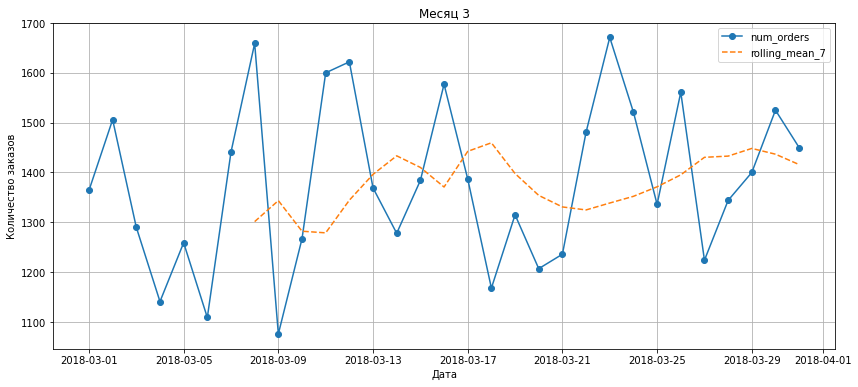

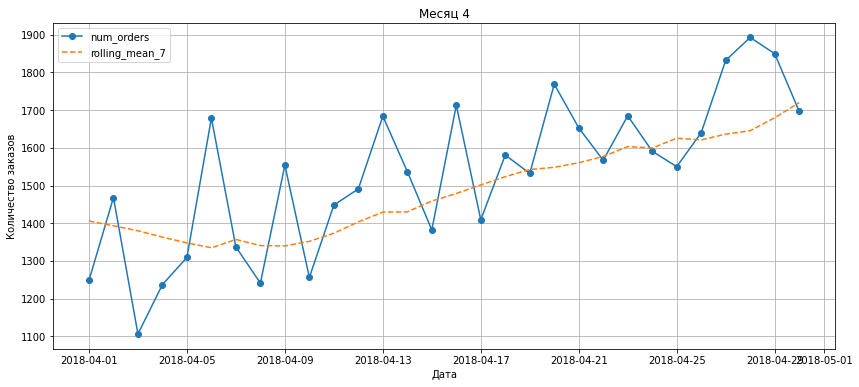

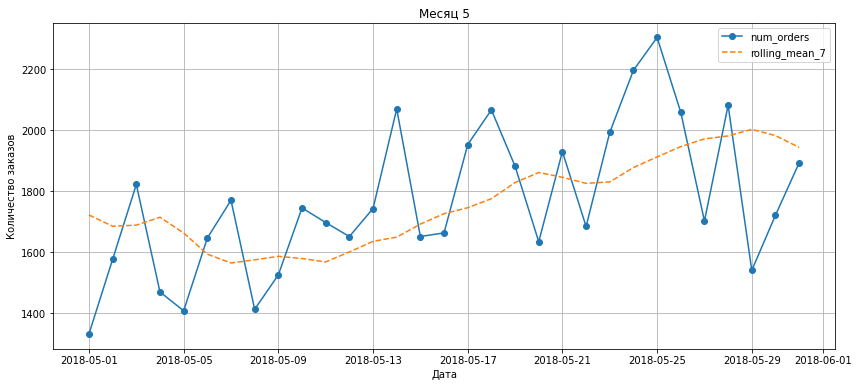

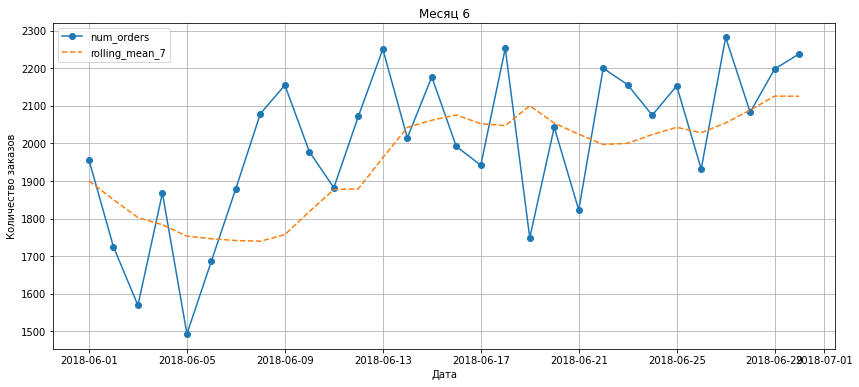

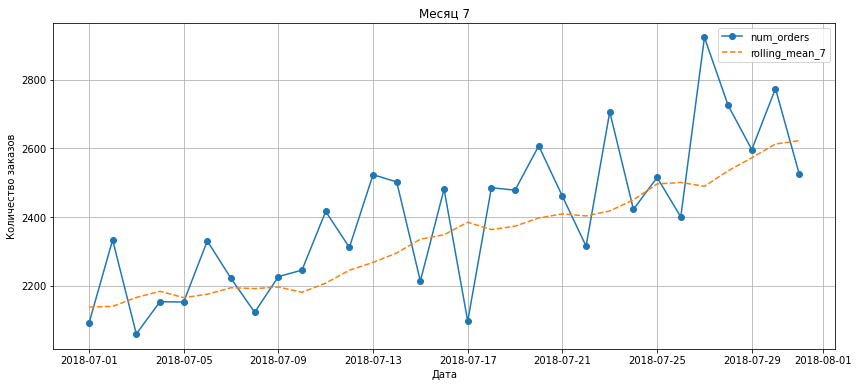

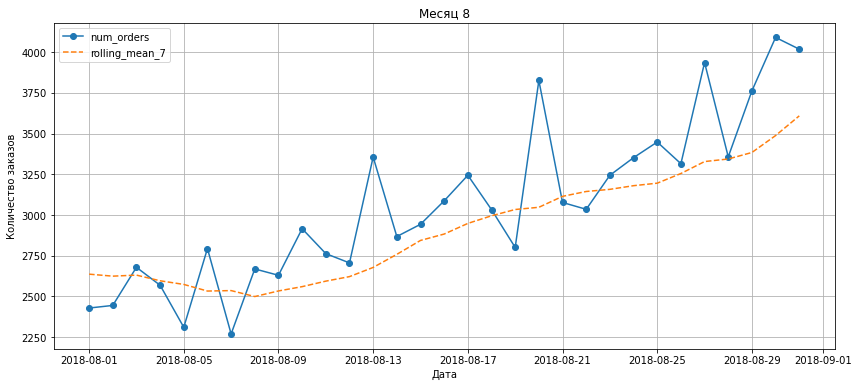

In [18]:
for month in unique_months:
    data_month = d_w_m[d_w_m['month'] == month]

    plt.figure(figsize=(14, 6)) 
    plt.plot(data_month.index, data_month['num_orders'], label='num_orders', marker='o')
    plt.plot(data_month.index, data_month['rolling_mean_7'], label='rolling_mean_7', linestyle='--')
    plt.title(f'Месяц {month}')
    plt.xlabel('Дата')
    plt.ylabel('Количество заказов')
    plt.legend()
    plt.grid(True)
    plt.show()

Видны подьемы в последний и первый рабочий день, похоже что данные из России, т.к видны праздники 8 марта, майские праздники и 12 июня

Виден рост скользящего среднего за 7 дней с 1300 до 3600 - **ряд НЕ стационарный**

Добавим категорию показывающую:
- стабильный день (рабочий среди рабочих, выходной среди выходных) -0 
- предвыходной/ 1
- первый выходной/  2
- последний выходной/ 3
- первый рабочий день/ 4 

In [19]:
cal = Russia()

In [20]:
cal.holidays(2018)

[(datetime.date(2018, 1, 1), 'New year'),
 (datetime.date(2018, 1, 2), 'Day After New Year'),
 (datetime.date(2018, 1, 3), 'Third Day after New Year'),
 (datetime.date(2018, 1, 4), 'Fourth Day after New Year'),
 (datetime.date(2018, 1, 5), 'Fifth Day after New Year'),
 (datetime.date(2018, 1, 6), 'Sixth Day after New Year'),
 (datetime.date(2018, 1, 7), 'Christmas'),
 (datetime.date(2018, 1, 8), 'Eighth Day after New Year'),
 (datetime.date(2018, 2, 23), 'Defendence of the Fatherland'),
 (datetime.date(2018, 3, 8), "International Women's Day"),
 (datetime.date(2018, 5, 1), 'The Day of Spring and Labour'),
 (datetime.date(2018, 5, 9), 'Victory Day'),
 (datetime.date(2018, 6, 12), 'National Day'),
 (datetime.date(2018, 11, 4), 'Day of Unity'),
 (datetime.date(2018, 11, 5), 'Day of Unity shift')]

В библиотеке не учтены переносы праздников и выходных, нужно будет править вручную

In [21]:
d_w_m['is_holiday'] = d_w_m.index.date.astype(object) 

In [22]:
d_w_m['is_holiday'] = d_w_m['is_holiday'].apply(lambda x: cal.is_holiday(x))

In [23]:
d_w_m['is_weekend'] = d_w_m.index.weekday >= 5

In [24]:
d_w_m.loc['2018-03-09', 'is_holiday'] = True
d_w_m.loc['2018-04-28', 'is_weekend'] = False
d_w_m.loc['2018-04-30', 'is_holiday'] = True
d_w_m.loc['2018-05-02', 'is_holiday'] = True
d_w_m.loc['2018-06-09', 'is_weekend'] = False
d_w_m.loc['2018-06-11', 'is_holiday'] = True

In [25]:
d_w_m['is_day_off'] = d_w_m['is_holiday'] | d_w_m['is_weekend']

In [26]:
cat_day = [0]
for i in range(1, len(d_w_m) - 1):
    prev_val = d_w_m.iloc[i - 1]['is_day_off']
    curr_val = d_w_m.iloc[i]['is_day_off']
    next_val = d_w_m.iloc[i + 1]['is_day_off']
    #print(i, prev_val, curr_val, next_val)
    if prev_val == 0 and curr_val == 0 and next_val == 1:
        cat_day.append(1)
    if prev_val == 1 and curr_val == 0 and next_val == 1:
        cat_day.append(1)        
    if prev_val == 0 and curr_val == 1 and next_val == 1:
        cat_day.append(2)
    if prev_val == 0 and curr_val == 1 and next_val == 0:
        cat_day.append(2)
    if prev_val == 1 and curr_val == 1 and next_val == 0:
        cat_day.append(3)
    if prev_val == 1 and curr_val == 0 and next_val == 0:
        cat_day.append(4)
    if curr_val ==  prev_val and curr_val == next_val:
        cat_day.append(0)
cat_day.append(1)

In [27]:
d_w_m['cat_off'] = cat_day

Посмотри новый график с учетом категорий

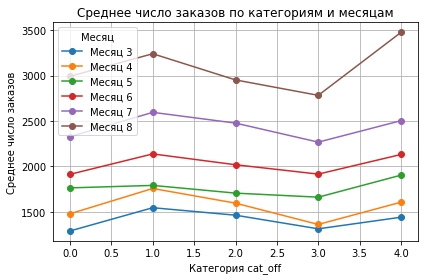

In [28]:
df_help_1 = d_w_m.pivot_table(index='month', columns='cat_off', values='num_orders', aggfunc='mean')
for month in df_help_1.index:
    plt.plot(df_help_1.columns, df_help_1.loc[month], marker='o', label=f'Месяц {month}')

plt.xlabel('Категория cat_off')
plt.ylabel('Среднее число заказов')
plt.title('Среднее число заказов по категориям и месяцам')
plt.grid(True)
plt.legend(title='Месяц')
plt.tight_layout()
plt.show()

Деление на категории в целом верно, сильно отличается только  05/МАЙ

Усредняя данные за целый день
 - Стабильный день и последний выходной - самые тихие
 - Предпраздничный и 1-й рабочий - самые горячие

Рассмотрим тренд и сезонность по дням

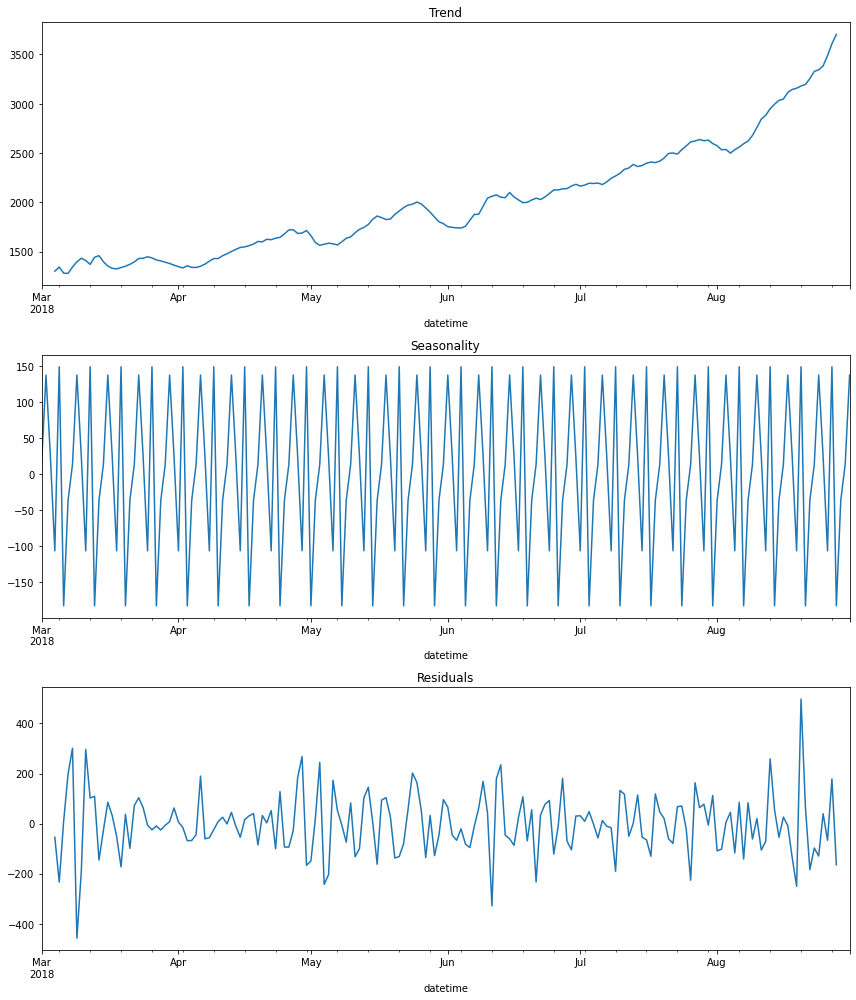

In [29]:
decomposed = seasonal_decompose(d_w_m['num_orders']) 

plt.figure(figsize=(12, 14))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

- Тренд - рост числа заказов - вероятно это рост доли сервиса на рынке, 
- Сезонность по дням недели - выраженная
- На праздничные дни показана просадка тренда и возростание шума (на 8 марта, на майские и 12 июня) - пики по шуму
- Пик шума и рост по тренду в конце августа - вероятно связан с окончанием каникул, 2-я половина августа особое время, но точно это можно сказать только сравнив данные за разные годы

### Рассмотрим заказы по часам

Присоединим категории выходных дней к исходному датафрейму по часам

In [30]:
df_1 = df_1.reset_index()
df_1['date'] = df_1['datetime'].dt.date

In [31]:
d_w_m = d_w_m.reset_index()
d_w_m['date'] = d_w_m['datetime'].dt.date

In [32]:
df_1 = df_1.merge(
    d_w_m[['date', 'is_holiday', 'is_weekend', 'is_day_off', 'cat_off']], 
    on='date', how='left')

In [33]:
df_1.set_index('datetime', inplace=True)
df_1.drop(labels='date', axis=1, inplace=True)

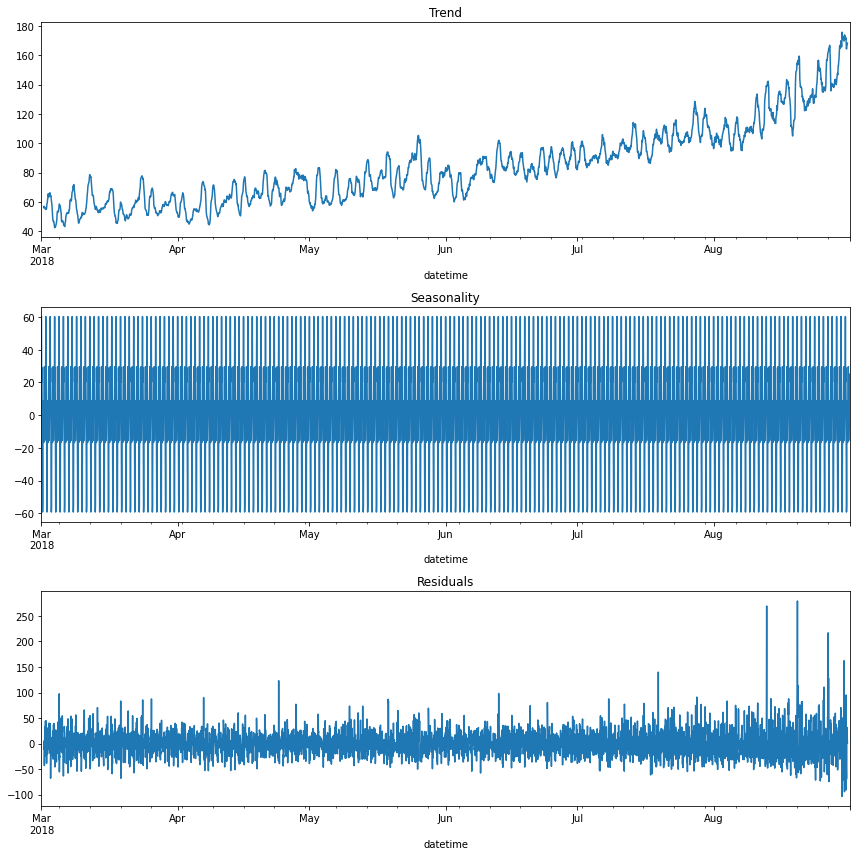

In [34]:
decomposed = seasonal_decompose(df_1['num_orders']) 

plt.figure(figsize=(12, 12))
plt.subplot(311)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

При таком варианте построения 
- график Тренд показывает изменение по дням
- график Сезонность - сезонность по часам
- Шум - показывает усиление в конце августа, подготовка к началу учебного года

Рассмотрим среднее и медианное кол-во заказов по дням недели по месяцам

In [35]:
df_1.head()

,num_orders,month,day,hour,week_num,dayofweek,roll_mean_24,is_holiday,is_weekend,is_day_off,cat_off
datetime,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,0,9,3,NaN,False,False,False,0
2018-03-01 01:00:00,85,3,1,1,9,3,NaN,False,False,False,0
2018-03-01 02:00:00,71,3,1,2,9,3,NaN,False,False,False,0
2018-03-01 03:00:00,66,3,1,3,9,3,NaN,False,False,False,0
2018-03-01 04:00:00,43,3,1,4,9,3,NaN,False,False,False,0


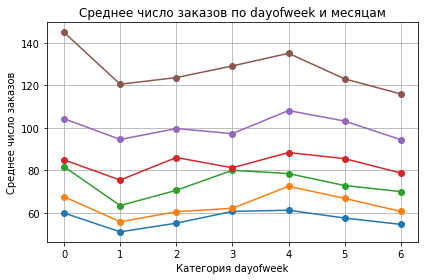

In [36]:
df_help_1 = df_1.pivot_table(index='month', columns='dayofweek', values='num_orders', aggfunc='mean')
for month in df_help_1.index:
    plt.plot(df_help_1.columns, df_help_1.loc[month], marker='o', label=f'Месяц {month}')

plt.xlabel('Категория dayofweek')
plt.ylabel('Среднее число заказов')
plt.title('Среднее число заказов по dayofweek и месяцам')
plt.grid(True)
plt.tight_layout()
plt.show()

- От месяца к месяцу - рост
- Понедельник и пятница самые загруженные
- вторник и воскресенье - самые спокойные
- Принципиальных отличий между месяцами нет

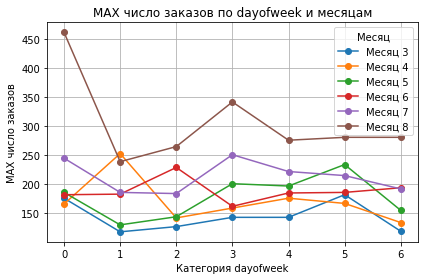

In [37]:
df_help_1 = df_1.pivot_table(index='month', columns='dayofweek', values='num_orders', aggfunc='max')
for month in df_help_1.index:
    plt.plot(df_help_1.columns, df_help_1.loc[month], marker='o', label=f'Месяц {month}')

plt.xlabel('Категория dayofweek')
plt.ylabel('MAX число заказов')
plt.title('MAX число заказов по dayofweek и месяцам')
plt.grid(True)
plt.legend(title='Месяц')
plt.tight_layout()
plt.show()

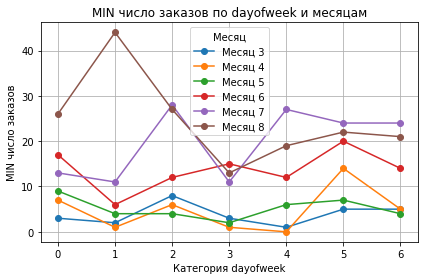

In [38]:
df_help_1 = df_1.pivot_table(index='month', columns='dayofweek', values='num_orders', aggfunc='min')
for month in df_help_1.index:
    plt.plot(df_help_1.columns, df_help_1.loc[month], marker='o', label=f'Месяц {month}')

plt.xlabel('Категория dayofweek')
plt.ylabel('MIN число заказов')
plt.title('MIN число заказов по dayofweek и месяцам')
plt.grid(True)
plt.legend(title='Месяц')
plt.tight_layout()
plt.show()

А для МИН и МАХ значений в час существует разброс и здесь строгой зависимости от месяца к месяцу нет

Рассмотрим заказы по часам внутри суток

In [39]:
df_help_1 = df_1.pivot_table(index='month' , columns='hour', values='num_orders', aggfunc='mean') #.reset_index()

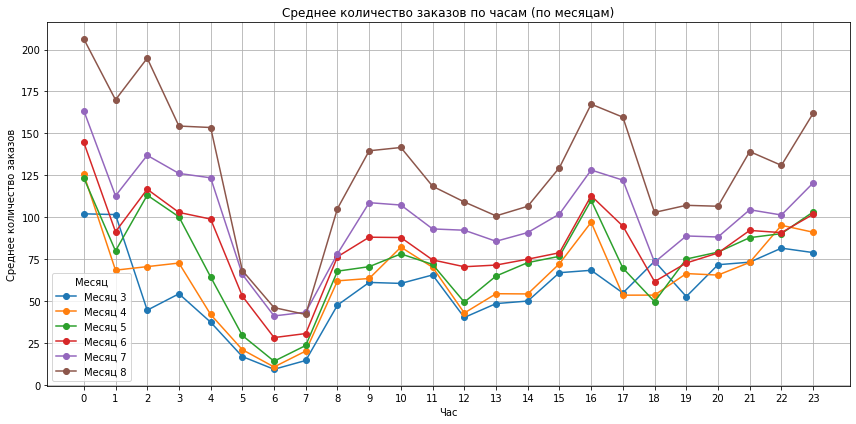

In [40]:
plt.figure(figsize=(12, 6))

# Для каждого месяца строим линию
for month in df_help_1.index:
    plt.plot(
        df_help_1.columns.astype(int),        
        df_help_1.loc[month].values,          
        marker='o',
        label=f'Месяц {month}'
    )

plt.title('Среднее количество заказов по часам (по месяцам)')
plt.xlabel('Час')
plt.ylabel('Среднее количество заказов')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='Месяц')
plt.tight_layout()
plt.show()

В целом по часовая загрузка по месяцам подобна.
- Есть время 5-7 часов когда загрузка минимальна и медленно растет - вероятно это время технического окна для обслуживания площадных сооружений
- время 2-4 часа ночи наоборот растет быстрее. 
- Возможно это связано с увеличением температуры воздуха т.к. при большой температуре снижается несущая способность Асфальтобетонных покрытий, а также для разбега самолета требуется большая длина полосы (а она константа) следовательно приходится снижать коммерческую загрузку самолета.

**Для более точного прогноза нужно собрать наблюдения по прибывающим по часам рейсам с наблюдениями сколько % пассажиров вызывает такси, и в дальнейщем следить за соблюдением рассписания в аропортах вылета и прилета. А также тип воздушного судна, ограничения на этот тип в аэропорту**

In [41]:
df_help_1 = df_1.pivot_table(index='dayofweek' , columns='hour', values='num_orders', aggfunc='mean')

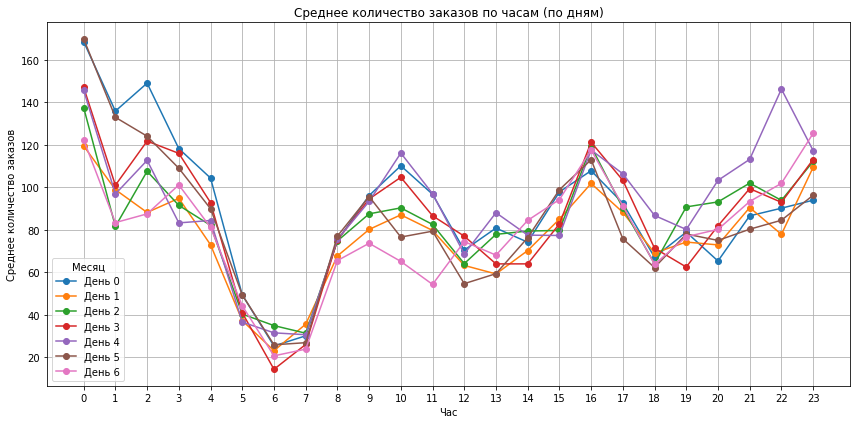

In [42]:
plt.figure(figsize=(12, 6))

for dayofweek in df_help_1.index:
    plt.plot(
        df_help_1.columns.astype(int),        
        df_help_1.loc[dayofweek].values,          
        marker='o',
        label=f'День {dayofweek}'
    )

plt.title('Среднее количество заказов по часам (по дням)')
plt.xlabel('Час')
plt.ylabel('Среднее количество заказов')
plt.xticks(range(0, 24))
plt.grid(True)
plt.legend(title='Месяц')
plt.tight_layout()
plt.show()

- Вечерний пик с 20 до 23- переходит в ночной 0-2 - ночь с пятницы на субботу
- В ночь с 2 до 4 - максимум дает ночь с воскресения на понедельник
- Утро с 5 до 7 - минимум
- Утром с 8 до 11 минимум с отрывом показывает воскресение
- В остальное время дни смешаны 

In [43]:
def make_features_2(data, max_lag):
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['roll_mean_3'] = data['num_orders'].shift().rolling(3).mean()
    data['roll_mean_6'] = data['num_orders'].shift().rolling(6).mean()
    data['roll_mean_12'] = data['num_orders'].shift().rolling(12).mean()
    data['roll_mean_48'] = data['num_orders'].shift().rolling(48).mean()
    data['roll_mean_168'] = data['num_orders'].shift().rolling(168).mean()

In [44]:
make_features_2(df_1, 168)

Рассмотрим получившийся ДатаФрейм и добавим скользящее среднее за 2 и 7 дней, 
    
А также уберем не информативные признаки связаные сдатой - month, week_num.

Также среди признаков 
- is_holiday - праздник (Гос праздники + переносы в соответсвии с производственным календарем)
- is_weekend - выходной (СБ ВС)
- is_day_off - не рабочий день (объединение 2-х предыдущих)
- cat_off категория дня:  
                        - стабильный день (рабочий среди рабочих, выходной среди выходных) -0
                        - предвыходной/ 1
                        - первый выходной/  2
                        - последний выходной/ 3
                        - первый рабочий день/ 4 

    оставляем только cat_off т.к 3 предыдущие признака нужны только для его создания  

In [45]:
df_1.drop(labels=['day', 'month', 'week_num', 'is_holiday', 'is_weekend', 'is_day_off'] , axis=1, inplace=True)

In [46]:
df_1.head(5)

,num_orders,hour,dayofweek,roll_mean_24,cat_off,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,lag_37,lag_38,lag_39,lag_40,lag_41,lag_42,lag_43,lag_44,lag_45,lag_46,lag_47,lag_48,lag_49,lag_50,lag_51,lag_52,lag_53,lag_54,lag_55,lag_56,lag_57,lag_58,lag_59,lag_60,lag_61,lag_62,lag_63,lag_64,lag_65,lag_66,lag_67,lag_68,lag_69,lag_70,lag_71,lag_72,lag_73,lag_74,lag_75,lag_76,lag_77,lag_78,lag_79,lag_80,lag_81,lag_82,lag_83,lag_84,lag_85,lag_86,lag_87,lag_88,lag_89,lag_90,lag_91,lag_92,lag_93,lag_94,lag_95,lag_96,lag_97,lag_98,lag_99,lag_100,lag_101,lag_102,lag_103,lag_104,lag_105,lag_106,lag_107,lag_108,lag_109,lag_110,lag_111,lag_112,lag_113,lag_114,lag_115,lag_116,lag_117,lag_118,lag_119,lag_120,lag_121,lag_122,lag_123,lag_124,lag_125,lag_126,lag_127,lag_128,lag_129,lag_130,lag_131,lag_132,lag_133,lag_134,lag_135,lag_136,lag_137,lag_138,lag_139,lag_140,lag_141,lag_142,lag_143,lag_144,lag_145,lag_146,lag_147,lag_148,lag_149,lag_150,lag_151,lag_152,lag_153,lag_154,lag_155,lag_156,lag_157,lag_158,lag_159,lag_160,lag_161,lag_162,lag_163,lag_164,lag_165,lag_166,lag_167,lag_168,roll_mean_3,roll_mean_6,roll_mean_12,roll_mean_48,roll_mean_168
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,0,3,NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,1,3,NaN,0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2,3,NaN,0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,3,NaN,0,71.0,85.0,124.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

Видны подьемы в последний и первый рабочий день, похоже что данные из России, т.к видны праздники 8 марта, майские праздники и 12 июня

Виден рост скользящего среднего за 7 дней с 1300 до 3600 - **ряд НЕ стационарный**

Добавим категорию показывающую:
- стабильный день (рабочий среди рабочих, выходной среди выходных) -0 
- предвыходной/ 1
- первый выходной/  2
- последний выходной/ 3
- первый рабочий день/ 4 
- Не все праздники учтены в библиотеке workalendar, пришлось править вручную

На графике Среднее число заказов по категориям и месяцам  видно

Деление на категории в целом верно, сильно отличается только  05/МАЙ

Усредняя данные за целый день
 - Стабильный день и последний выходной - самые тихие
 - Предпраздничный и 1-й рабочий - самые горячие

На графиках тренд и сезонность по дням видно
- Тренд - рост числа заказов - вероятно это рост доли сервиса на рынке, 
- Сезонность по дням недели - выраженная
- На праздничные дни показана просадка тренда и возростание шума (на 8 марта, на майские и 12 июня) - пики по шуму
- Пик шума и рост по тренду в конце августа - вероятно связан с окончанием каникул, 2-я половина августа особое время, но точно это можно сказать только сравнив данные за разные годы

На графиках тренд и сезонность по часам видно
- график Тренд показывает изменение по дням
- график Сезонность - сезонность по часам
- Шум - показывает усиление в конце августа, подготовка к началу учебного года

Рассмотривая среднее и медианное кол-во заказов по дням недели по месяцам
На графике Среднее число заказов по dayofweek и месяцам видно
- От месяца к месяцу - рост
- Понедельник и пятница самые загруженные
- вторник и воскресенье - самые спокойные
- Принципиальных отличий между месяцами нет
- А для МИН и МАХ значений в час существует разброс и здесь строгой зависимости от месяца к месяцу нет

Рассмотрим заказы по часам внутри суток
На графике Среднее количество заказов по часам (по месяцам) видно

В целом по часовая загрузка по месяцам подобна.
- Есть время 5-7 часов когда загрузка минимальна и медленно растет - вероятно это время технического окна для обслуживания площадных сооружений
- время 2-4 часа ночи наоборот растет быстрее. 
- Возможно это связано с увеличением температуры воздуха т.к. при большой температуре снижается несущая способность Асфальтобетонных покрытий, а также для разбега самолета требуется большая длина полосы (а она константа) следовательно приходится снижать коммерческую загрузку самолета.

**Для более точного прогноза нужно собрать наблюдения по прибывающим по часам рейсам с наблюдениями сколько % пассажиров вызывает такси, и в дальнейщем следить за соблюдением рассписания в аропортах вылета и прилета. А также тип воздушного судна, ограничения на этот тип в аэропорту**

А на графике Среднее количество заказов по часам (по дням)
- Вечерний пик с 20 до 23- переходит в ночной 0-2 - ночь с пятницы на субботу
- В ночь с 2 до 4 - максимум дает ночь с воскресения на понедельник
- Утро с 5 до 7 - минимум
- Утром с 8 до 11 минимум с отрывом показывает воскресение
- В остальное время дни смешаны 

## Обучение

### LinearRegression - с ОНЕ кодировщиком

In [47]:
RANDOM_STATE = 42

In [48]:
train_2, test_2 = train_test_split(df_1, shuffle=False, test_size=0.1)
train_2 = train_2.dropna()

print(train_2.index.min(), train_2.index.max())
print(test_2.index.min(), test_2.index.max())

2018-03-08 00:00:00 2018-08-13 13:00:00
2018-08-13 14:00:00 2018-08-31 23:00:00


In [49]:
train_y_2 = train_2['num_orders']
train_x_2 = train_2.drop(labels='num_orders', axis=1)
test_y_2 = test_2['num_orders']
test_x_2 = test_2.drop(labels='num_orders', axis=1)

In [50]:
list_of_columns_1 = list(df_1.columns)

In [51]:
lag_cols_2 = [col for col in train_x_2.columns if col.startswith('lag_')]
roll_cols_2 = [col for col in train_x_2.columns if col.startswith('roll_mean')]
cat_cols_2 = ['dayofweek', 'hour', 'cat_off']   

In [52]:
list_of_columns_2 = lag_cols_2 + roll_cols_2 + cat_cols_2

In [53]:
diff1 = set(list_of_columns_1) - set(list_of_columns_2)
diff2 = set(list_of_columns_2) - set(list_of_columns_1)

print("Только в list1:", diff1)
print("Только в list2:", diff2)

Только в list1: {'num_orders'}
Только в list2: set()


In [54]:
ohe_pipe_2 = Pipeline(
    [
        (
            'simpleImputer_before_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        ),
        (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [55]:
preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), lag_cols_2 + roll_cols_2),
        ('cat', ohe_pipe_2, cat_cols_2)
    ]
)

In [56]:
model_2 = Pipeline(steps=[
    ('preprocess', preprocessor_2),
    ('feature_select', SelectFromModel(Lasso(alpha=0.1, random_state=RANDOM_STATE))),  
    ('reg', LinearRegression())
])

In [57]:
tscv_2 = TimeSeriesSplit(n_splits=5)

In [58]:
param_grid_2 = {
    'feature_select__estimator__alpha': [0.1, 1, 10]
}

In [59]:
grid_search_2 = GridSearchCV(
    model_2,
    param_grid_2,
    cv=tscv_2,
    scoring='neg_root_mean_squared_error'
)

In [60]:
grid_search_2.fit(train_x_2, train_y_2)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocess',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'lag_4',
                                                                          'lag_5',
                                                                          'lag_6',
                                                                          'lag_7',
                                                                          'lag_8',
                                                                          'lag_9',
                                                                          'lag_10',
                                                                          'lag_11',
                                                                          'lag_12',
                                                                          'lag_13',
                                                                          'lag_14',
                                                                          'lag_15',
                                                                          'lag_16',
                                                                          'lag_17',
                                                                          'lag_18',
                                                                          'lag_19',
                                                                          'lag_2...
                                                                                                        handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('simpleImputer_after_ohe',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['dayofweek',
                                                                          'hour',
                                                                          'cat_off'])])),
                                       ('feature_select',
                                        SelectFromModel(estimator=Lasso(alpha=0.1,
                                                                        random_state=42))),
                                       ('reg', LinearRegression())]),
             param_grid={'feature_select__estimator__alpha': [0.1, 1, 10]},
             scoring='neg_root_mean_squared_error')

In [61]:
print('Лучшая модель и её параметры:\n\n', grid_search_2.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocess',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11', 'lag_12',
                                                   'lag_13', 'lag_14', 'lag_15',
                                                   'lag_16', 'lag_17', 'lag_18',
                                                   'lag_19', 'lag_20', 'lag_21',
                                                   'lag_22', 'lag_23', 'lag_24',
                                                   'lag_25', 'lag_26', 'lag_27',
                                                   'lag_28', 'lag_29', 'lag_30', .....
                                                  Pipel

In [62]:
result_2 = pd.DataFrame(grid_search_2.cv_results_)
result_2 = result_2.sort_values('rank_test_score')
display(result_2.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_feature_select__estimator__alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
1,0.319524,0.066689,0.117268,0.032065,1.0,{'feature_select__estimator__alpha': 1},-1.914767e+01,-20.524084,-21.257274,-21.636365,-27.652109,-2.204350e+01,2.930353e+00,1
2,0.156094,0.061562,0.086461,0.049769,10.0,{'feature_select__estimator__alpha': 10},-1.851145e+01,-22.217403,-21.744293,-21.502035,-28.290904,-2.245322e+01,3.196218e+00,2
0,0.543055,0.147161,0.174831,0.037025,0.1,{'feature_select__estimator__alpha': 0.1},-3.330356e+12,-20.760353,-21.346565,-22.422878,-27.377045,-6.660712e+11,1.332142e+12,3


In [63]:
display('Метрика RMSE для лучшей модели LinearRegression:', grid_search_2.best_score_*-1)

'Метрика RMSE для лучшей модели LinearRegression:'

22.043500947285118

### KNR/Tree/Forest

In [64]:
lag_cols_3 = [col for col in train_x_2.columns if col.startswith('lag_')]
roll_cols_3 = [col for col in train_x_2.columns if col.startswith('roll_mean')]
cat_cols_3 = ['dayofweek', 'hour', 'cat_off']   

In [65]:
ohe_pipe_3 = Pipeline(
    [
        (
            'simpleImputer_before_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ohe', 
            OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        ),
        (
            'simpleImputer_after_ohe', 
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [66]:
preprocessor_3 = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), lag_cols_3 + roll_cols_3),
        ('cat', ohe_pipe_3, cat_cols_3)
    ]
)

In [67]:
pipe_final_3 = Pipeline(
    [
        ('preprocessor', preprocessor_3),
        ('selector', SelectKBest()),
        ('models', KNeighborsRegressor())
    ]
)

In [68]:
param_grid_3 = [
    
    {
        'models': [KNeighborsRegressor()],  
        'models__n_neighbors': range(10, 30, 2),  
        'selector__k': range(3, 10)
    },
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__min_samples_leaf': range(1, 7),
        'models__max_depth': range(5, 10),
        'preprocessor__num': [StandardScaler()],
        'selector__k' : range(3, 20)
    },
    {
        'models': [RandomForestRegressor(random_state=RANDOM_STATE)],
        'models__n_estimators': [150, 200, 250],
        'models__max_depth': range(6, 9),
        'selector__k' : range(12, 17)
    }
] 

In [69]:
tscv_3 = TimeSeriesSplit(n_splits=5)

In [70]:
grid_search_3 = GridSearchCV(
    pipe_final_3,
    param_grid_3,
    cv=tscv_3,
    scoring='neg_root_mean_squared_error'
)

In [71]:
grid_search_3.fit(train_x_2, train_y_2)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'lag_4',
                                                                          'lag_5',
                                                                          'lag_6',
                                                                          'lag_7',
                                                                          'lag_8',
                                                                          'lag_9',
                                                                          'lag_10',
                                                                          'lag_11',
                                                                          'lag_12',
                                                                          'lag_13',
                                                                          'lag_14',
                                                                          'lag_15',
                                                                          'lag_16',
                                                                          'lag_17',
                                                                          'lag_18',
                                                                          'lag_19',
                                                                          'lag...
                         {'models': [DecisionTreeRegressor(random_state=42)],
                          'models__max_depth': range(5, 10),
                          'models__min_samples_leaf': range(1, 7),
                          'preprocessor__num': [StandardScaler()],
                          'selector__k': range(3, 20)},
                         {'models': [RandomForestRegressor(random_state=42)],
                          'models__max_depth': range(6, 9),
                          'models__n_estimators': [150, 200, 250],
                          'selector__k': range(12, 17)}],
             scoring='neg_root_mean_squared_error')

In [72]:
print('Лучшая модель и её параметры:\n\n', grid_search_3.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11', 'lag_12',
                                                   'lag_13', 'lag_14', 'lag_15',
                                                   'lag_16', 'lag_17', 'lag_18',
                                                   'lag_19', 'lag_20', 'lag_21',
                                                   'lag_22', 'lag_23', 'lag_24',
                                                   'lag_25', 'lag_26', 'lag_27',
                                                   'lag_28', 'lag_29', 'lag_30',...
                                                  Pipeli

In [73]:
result_3 = pd.DataFrame(grid_search_3.cv_results_)
result_3 = result_3.sort_values('rank_test_score')
display(result_3.head(7))

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__n_neighbors,param_selector__k,param_models__max_depth,param_models__min_samples_leaf,param_preprocessor__num,param_models__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
602,1.650417,0.651960,0.029828,0.000608,RandomForestRegressor(random_state=42),NaN,14,7.0,NaN,NaN,200.0,{'models': RandomForestRegressor(random_state=...,-19.233223,-21.877079,-21.541293,-22.114373,-28.950591,-22.743312,3.269306,1
598,1.336273,0.526027,0.025088,0.000378,RandomForestRegressor(random_state=42),NaN,15,7.0,NaN,NaN,150.0,{'models': RandomForestRegressor(random_state=...,-19.264953,-21.906785,-21.560094,-22.090174,-28.913249,-22.747051,3.246333,2
603,1.807023,0.730385,0.029649,0.001824,RandomForestRegressor(random_state=42),NaN,15,7.0,NaN,NaN,200.0,{'models': RandomForestRegressor(random_state=...,-19.269123,-21.918508,-21.550832,-22.094365,-28.906748,-22.747915,3.242877,3
597,1.243954,0.500463,0.025281,0.000648,RandomForestRegressor(random_state=42),NaN,14,7.0,NaN,NaN,150.0,{'models': RandomForestRegressor(random_state=...,-19.232903,-21.901798,-21.551239,-22.121186,-28.980167,-22.757459,3.278309,4
607,2.059561,0.823078,0.033897,0.000681,RandomForestRegressor(random_state=42),NaN,14,7.0,NaN,NaN,250.0,{'models': RandomForestRegressor(random_state=...,-19.245149,-21.946806,-21.538251,-22.111602,-28.964497,-22.761261,3.268771,5
608,2.196466,0.879360,0.034205,0.000490,RandomForestRegressor(random_state=42),NaN,15,7.0,NaN,NaN,250.0,{'models': RandomForestRegressor(random_state=...,-19.268962,-21.986896,-21.550614,-22.103459,-28.899672,-22.761921,3.236487,6
601,1.541362,0.596754,0.030129,0.000497,RandomForestRegressor(random_state=42),NaN,13,7.0,NaN,NaN,200.0,{'models': RandomForestRegressor(random_state=...,-19.246794,-21.843744,-21.600499,-22.181071,-28.949501,-22.764322,3.261030,7


In [74]:
display('Метрика RMSE для лучшей модели:', grid_search_3.best_score_*-1)

'Метрика RMSE для лучшей модели:'

22.743311975694773

### CatBoostRegressor

In [75]:
pipe_final_cb = Pipeline(
    steps=[
        ('preprocessor', preprocessor_3),  
        ('selector', SelectKBest()),       
        ('model', CatBoostRegressor(
            verbose=0,
            loss_function='RMSE',
            random_state=RANDOM_STATE
        ))
    ]
)

In [76]:
param_grid_cb = {
    'selector__k': [5, 6, 7, 8, 9, 10],
    'model__depth': [4, 6],
    'model__iterations': [100],
    'model__learning_rate': [0.05]
}

In [77]:
tscv = TimeSeriesSplit(n_splits=5)

In [78]:
grid_cb = GridSearchCV(
    estimator=pipe_final_cb,
    param_grid=param_grid_cb,
    cv=tscv,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1
)

In [79]:
grid_cb.fit(train_x_2, train_y_2)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         StandardScaler(),
                                                                         ['lag_1',
                                                                          'lag_2',
                                                                          'lag_3',
                                                                          'lag_4',
                                                                          'lag_5',
                                                                          'lag_6',
                                                                          'lag_7',
                                                                          'lag_8',
                                                                          'lag_9',
                                                                          'lag_10',
                                                                          'lag_11',
                                                                          'lag_12',
                                                                          'lag_13',
                                                                          'lag_14',
                                                                          'lag_15',
                                                                          'lag_16',
                                                                          'lag_17',
                                                                          'lag_18',
                                                                          'lag_19',
                                                                          'lag...
                                                                                         ('simpleImputer_after_ohe',
                                                                                          SimpleImputer(strategy='most_frequent'))]),
                                                                         ['dayofweek',
                                                                          'hour',
                                                                          'cat_off'])])),
                                       ('selector', SelectKBest()),
                                       ('model',
                                        <catboost.core.CatBoostRegressor object at 0x7f96612f7190>)]),
             n_jobs=-1,
             param_grid={'model__depth': [4, 6], 'model__iterations': [100],
                         'model__learning_rate': [0.05],
                         'selector__k': [5, 6, 7, 8, 9, 10]},
             scoring='neg_root_mean_squared_error')

In [80]:
print('Лучшая модель и её параметры:\n\n', grid_cb.best_estimator_)

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['lag_1', 'lag_2', 'lag_3',
                                                   'lag_4', 'lag_5', 'lag_6',
                                                   'lag_7', 'lag_8', 'lag_9',
                                                   'lag_10', 'lag_11', 'lag_12',
                                                   'lag_13', 'lag_14', 'lag_15',
                                                   'lag_16', 'lag_17', 'lag_18',
                                                   'lag_19', 'lag_20', 'lag_21',
                                                   'lag_22', 'lag_23', 'lag_24',
                                                   'lag_25', 'lag_26', 'lag_27',
                                                   'lag_28', 'lag_29', 'lag_30',...
                                                  Pipeli

In [81]:
result_4 = pd.DataFrame(grid_cb.cv_results_)
result_4 = result_4.sort_values('rank_test_score')
display(result_4.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__depth,param_model__iterations,param_model__learning_rate,param_selector__k,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
10,0.781125,0.058522,0.011860,0.000280,6,100,0.05,9,"{'model__depth': 6, 'model__iterations': 100, ...",-19.037371,-21.468816,-21.041901,-22.008279,-28.945650,-22.500403,3.375422,1
5,0.673134,0.078484,0.011664,0.000266,4,100,0.05,10,"{'model__depth': 4, 'model__iterations': 100, ...",-18.940456,-21.598506,-21.148197,-21.856984,-29.142111,-22.537251,3.459323,2
11,0.831509,0.034153,0.011805,0.000112,6,100,0.05,10,"{'model__depth': 6, 'model__iterations': 100, ...",-19.329723,-21.515720,-21.269130,-21.835488,-28.942208,-22.578454,3.299920,3
4,0.664086,0.096282,0.011479,0.000313,4,100,0.05,9,"{'model__depth': 4, 'model__iterations': 100, ...",-19.039521,-21.734851,-21.096949,-21.911856,-29.155188,-22.587673,3.438835,4
2,0.640790,0.051159,0.011851,0.000412,4,100,0.05,7,"{'model__depth': 4, 'model__iterations': 100, ...",-19.027765,-21.650179,-21.813472,-21.578631,-29.468079,-22.707625,3.533764,5


In [82]:
display('Метрика RMSE для лучшей модели:', grid_cb.best_score_*-1)

'Метрика RMSE для лучшей модели:'

22.500403442905927

## Тестирование

Сравниваем модели по результатам кросс-валидации через TimeSeriesSplit

In [83]:
col_tab = ['RMSE_train']
name_model = ['LinearRegression_2', result_3.iloc[0]['param_models'], 'CatBoost']
final_tab = pd.DataFrame(index=name_model, columns=col_tab)
final_tab['RMSE_train'] = (-result_2.iloc[0]['mean_test_score'], -result_3.iloc[0]['mean_test_score'], 
                           -result_4.iloc[0]['mean_test_score'])
display(final_tab)   

,RMSE_train
LinearRegression_2,22.043501
RandomForestRegressor(random_state=42),22.743312
CatBoost,22.500403


LinearRegression_2 - показала лучший результат

Ваполним проверку обученой модели на всей Тренировочной выборке и на Тестовой выборке

In [84]:
y_pred_2=grid_search_2.best_estimator_.predict(test_x_2)
print("Значение метрики RMSE обучающей выборки:", root_mean_squared_error(train_y_2, grid_search_2.best_estimator_.predict(train_x_2)))
print("Значение метрики RMSE тестовой выборки:", root_mean_squared_error(test_y_2, y_pred_2))

Значение метрики RMSE обучающей выборки: 21.11541502367505
Значение метрики RMSE тестовой выборки: 34.381784684850835


Показания на тренировочной выборке практичеки не отличаются, а вот на Тестовой происходит существенное ухудшение качества.

Тем не менее RMSE тестовой выборки: 34.381784684850835 < 48 значит требуемое условие соблюдено.

Рассмотрим какие признаки отобрала модель для работы

In [85]:
best_model = grid_search_2.best_estimator_

mask = best_model.named_steps['feature_select'].get_support()

feature_names = best_model.named_steps['preprocess'].get_feature_names_out()

selected_features = feature_names[mask]

print("Выбранные признаки:")
print(selected_features)

Выбранные признаки:
['num__lag_1' 'num__lag_2' 'num__lag_24' 'num__lag_28' 'num__lag_47'
 'num__lag_48' 'num__lag_72' 'num__lag_78' 'num__lag_96' 'num__lag_120'
 'num__lag_147' 'num__lag_167' 'num__lag_168' 'num__roll_mean_12']


Данные о выходных и праздниках оказались не информативны.


In [86]:
selected_features = best_model.named_steps['preprocess'].get_feature_names_out()[
    best_model.named_steps['feature_select'].get_support()
]

coefficients = best_model.named_steps['reg'].coef_

feature_importance_df = pd.DataFrame({
    'feature': selected_features,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values(by='abs_coefficient', ascending=False)
в
for _, row in feature_importance_df.iterrows():
    print(f"{row['feature']}: {row['coefficient']:.4f}")

num__lag_168: 13.1654
num__lag_48: 4.6048
num__lag_72: 3.6831
num__roll_mean_12: 3.5566
num__lag_96: 3.5529
num__lag_120: 3.3809
num__lag_24: 3.1502
num__lag_1: 2.9528
num__lag_167: 2.0489
num__lag_147: -1.7638
num__lag_78: -1.5693
num__lag_2: 1.2939
num__lag_28: -0.9882
num__lag_47: 0.7660


- Самый важный признак - интенсивность поездок 168 часов назад - т.е ровно неделю назад. 
- Также в лидерах 2-х, 3-х, 4-х, 5-ти, 6-ти и 1-но суточно отстающая интенсивность.

- В общем интенсивность вызовов будет такая же как и на прошлой недели + рост/снижение по тренду

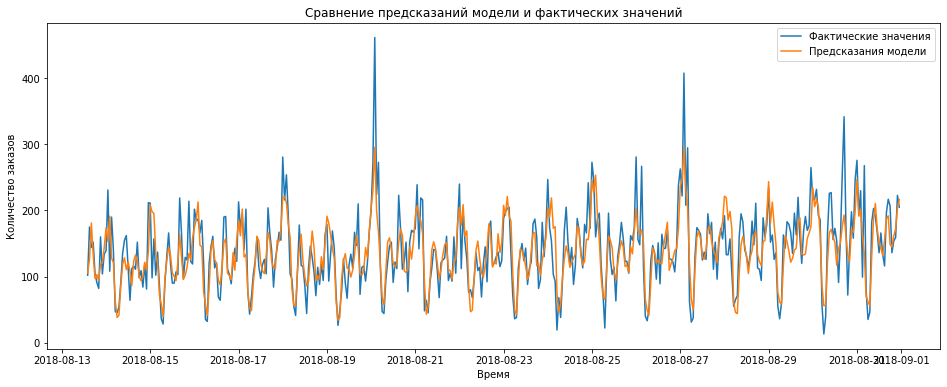

In [87]:
plt.figure(figsize=(16, 6))
sns.lineplot(y=test_y_2, x = test_y_2.index)
sns.lineplot(y=y_pred_2, x = test_y_2.index).set(title='Сравнение предсказаний модели и фактических значений',
     xlabel='Время', ylabel='Количество заказов');
plt.legend(['Фактические значения', 'Предсказания модели']);

Модель практически везде сгладила пики минимума и максимума, 
- наибольшее расхлждение ночь с ВС на ПН и с ПТ на СБ - можно добавить в модель информацию за прошлый год (при этом учитывать перевод часов, смещение дней недели) 
- практичеки все утра 5-7 часов модель завышает. - здесь можно провести рекламу типа "Сервис заботится о клиентах и наши машины всегда ждут Вас когда транспорта на улицах ещё нет"

### Вывод

Представлены данные:

- Представленный период с 2018-03-01 00:00:00 по 2018-08-31 23:50:00 (вкл последние 10 минут августа) 
- Пропусков нет
- Минимум заказов за 10 минут - 0
- Максимум заказов за 10 минут - 119
- Медиана за 10 минут - 13

Видны подьемы в последний и первый рабочий день, похоже что данные из России, т.к видны праздники 8 марта, майские праздники и 12 июня

Виден рост скользящего среднего за 7 дней с 1300 до 3600 - **ряд НЕ стационарный**

Добавим категорию показывающую:
- стабильный день (рабочий среди рабочих, выходной среди выходных) -0 
- предвыходной/ 1
- первый выходной/  2
- последний выходной/ 3
- первый рабочий день/ 4 
- Не все праздники учтены в библиотеке workalendar, пришлось править вручную

На графике Среднее число заказов по категориям и месяцам  видно

Деление на категории в целом верно, сильно отличается только  05/МАЙ

Усредняя данные за целый день
 - Стабильный день и последний выходной - самые тихие
 - Предпраздничный и 1-й рабочий - самые горячие

На графиках тренд и сезонность по дням видно
- Тренд - рост числа заказов - вероятно это рост доли сервиса на рынке, 
- Сезонность по дням недели - выраженная
- На праздничные дни показана просадка тренда и возростание шума (на 8 марта, на майские и 12 июня) - пики по шуму
- Пик шума и рост по тренду в конце августа - вероятно связан с окончанием каникул, 2-я половина августа особое время, но точно это можно сказать только сравнив данные за разные годы

На графиках тренд и сезонность по часам видно
- график Тренд показывает изменение по дням
- график Сезонность - сезонность по часам
- Шум - показывает усиление в конце августа, подготовка к началу учебного года

Рассмотривая среднее и медианное кол-во заказов по дням недели по месяцам
На графике Среднее число заказов по dayofweek и месяцам видно
- От месяца к месяцу - рост
- Понедельник и пятница самые загруженные
- вторник и воскресенье - самые спокойные
- Принципиальных отличий между месяцами нет
- А для МИН и МАХ значений в час существует разброс и здесь строгой зависимости от месяца к месяцу нет

Рассмотрим заказы по часам внутри суток
На графике Среднее количество заказов по часам (по месяцам) видно

В целом по часовая загрузка по месяцам подобна.
- Есть время 5-7 часов когда загрузка минимальна и медленно растет - вероятно это время технического окна для обслуживания площадных сооружений
- время 2-4 часа ночи наоборот растет быстрее. 
- Возможно это связано с увеличением температуры воздуха т.к. при большой температуре снижается несущая способность Асфальтобетонных покрытий, а также для разбега самолета требуется большая длина полосы (а она константа) следовательно приходится снижать коммерческую загрузку самолета.

**Для более точного прогноза нужно собрать наблюдения по прибывающим по часам рейсам с наблюдениями сколько % пассажиров вызывает такси, и в дальнейщем следить за соблюдением рассписания в аропортах вылета и прилета. А также тип воздушного судна, ограничения на этот тип в аэропорту**

А на графике Среднее количество заказов по часам (по дням)
- Вечерний пик с 20 до 23- переходит в ночной 0-2 - ночь с пятницы на субботу
- В ночь с 2 до 4 - максимум дает ночь с воскресения на понедельник
- Утро с 5 до 7 - минимум
- Утром с 8 до 11 минимум с отрывом показывает воскресение
- В остальное время дни смешаны 

Обучены модели 
- LinearRegression
- KNeighborsRegressor()
- DecisionTreeRegressor
- RandomForestRegressor
- CatBoost

По результатам кросс-валидации через TimeSeriesSplit LinearRegression - показала лучший результат
- RMSE тестовой выборки: 34.381784684850835 < 48 значит тредемое условие соблюдено.

- Самый важный признак - интенсивность поездок 168 часов назад - т.е ровно неделю назад. 
- Также в лидерах 2-х, 3-х, 4-х, 5-ти, 6-ти и 1-но суточно отстающая интенсивность.

**- В общем интенсивность вызовов будет такая же как и на прошлой недели + рост/снижение по тренду**

Модель практически везде сгладила пики минимума и максимума, 

- наибольшее расхлждение ночь с ВС на ПН и с ПТ на СБ - можно добавить в модель информацию за прошлый год (при этом учитывать перевод часов, смещение дней недели) 
- практичеки все утра 5-7 часов модель завышает. - здесь можно провести рекламу типа "Сервис заботится о клиентах и наши машины всегда ждут Вас когда транспорта на улицах ещё нет"